In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json
import os
import tweepy
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
%matplotlib inline

## Data Gathering

Read twitter_archive_enchanced.csv in pandas

In [2]:
enhanced_archive = pd.read_csv('twitter-archive-enhanced.csv')

Get image_predictioniction.tsv file from internet using requests library


In [3]:
#image predictions data url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

#write the response content to a file to read later in pandas
response = requests.get(url)
with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)

In [4]:
image_prediction = pd.read_csv('image-predictions.tsv', sep ='\t')

Get tweets retweet count and favorite("like") count from  Twitter API using tweepy library

In [7]:
api_key = '######'
secret_key = '######'
access_token = '#######'

#authenticate and get Twitter API access
auth = tweepy.OAuth2AppHandler(
api_key,secret_key)

api = tweepy.API(auth,wait_on_rate_limit= True)


Retrieve each tweets JSON data and save them in tweet_json.txt file

In [8]:
"""
source code url: https://video.udacity-data.com/topher/2018/November/5be5fb4c_twitter-api/twitter-api.py
"""
tweet_ids = enhanced_archive.tweet_id
print("Number of Tweet IDs {}".format(len(tweet_ids)))

#to determine the progress of saved files
count = 0
#Store the ids with failed query in a dict
fails_dict = {}
start_timer = timer()

#Save each JSON data into tweet_json.txt file
with open('tweet-json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print('{a} : {b}'.format(a = count, b = tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            json_string = tweet._json
            json.dump(json_string, outfile)
            outfile.write('\n')
            print('Success')
        except tweepy.TweepyException as error:
            print('failed')
            fails_dict[tweet_id] = error
            pass
end_timer = timer()

print(end_timer - start_timer)
print(fails_dict)

Number of Tweet IDs 2356
1 : 892420643555336193
Success
2 : 892177421306343426
Success
3 : 891815181378084864
Success
4 : 891689557279858688
Success
5 : 891327558926688256
Success
6 : 891087950875897856
Success
7 : 890971913173991426
Success
8 : 890729181411237888
Success
9 : 890609185150312448
Success
10 : 890240255349198849
Success
11 : 890006608113172480
Success
12 : 889880896479866881
Success
13 : 889665388333682689
Success
14 : 889638837579907072
Success
15 : 889531135344209921
Success
16 : 889278841981685760
Success
17 : 888917238123831296
Success
18 : 888804989199671297
Success
19 : 888554962724278272
Success
20 : 888202515573088257
failed
21 : 888078434458587136
Success
22 : 887705289381826560
Success
23 : 887517139158093824
Success
24 : 887473957103951883
Success
25 : 887343217045368832
Success
26 : 887101392804085760
Success
27 : 886983233522544640
Success
28 : 886736880519319552
Success
29 : 886680336477933568
Success
30 : 886366144734445568
Success
31 : 886267009285017600
S

Success
253 : 844973813909606400
Success
254 : 844704788403113984
failed
255 : 844580511645339650
Success
256 : 844223788422217728
Success
257 : 843981021012017153
Success
258 : 843856843873095681
Success
259 : 843604394117681152
Success
260 : 843235543001513987
Success
261 : 842892208864923648
failed
262 : 842846295480000512
Success
263 : 842765311967449089
Success
264 : 842535590457499648
Success
265 : 842163532590374912
Success
266 : 842115215311396866
Success
267 : 841833993020538882
Success
268 : 841680585030541313
Success
269 : 841439858740625411
Success
270 : 841320156043304961
Success
271 : 841314665196081154
Success
272 : 841077006473256960
Success
273 : 840761248237133825
Success
274 : 840728873075638272
Success
275 : 840698636975636481
Success
276 : 840696689258311684
Success
277 : 840632337062862849
Success
278 : 840370681858686976
Success
279 : 840268004936019968
Success
280 : 839990271299457024
Success
281 : 839549326359670784
Success
282 : 839290600511926273
failed
283 :

Success
502 : 813096984823349248
Success
503 : 813081950185472002
Success
504 : 813066809284972545
Success
505 : 813051746834595840
Success
506 : 812781120811126785
Success
507 : 812747805718642688
failed
508 : 812709060537683968
Success
509 : 812503143955202048
Success
510 : 812466873996607488
Success
511 : 812372279581671427
Success
512 : 811985624773361665
Success
513 : 811744202451197953
Success
514 : 811647686436880384
Success
515 : 811627233043480576
Success
516 : 811386762094317568
Success
517 : 810984652412424192
Success
518 : 810896069567610880
Success
519 : 810657578271330305
Success
520 : 810284430598270976
Success
521 : 810254108431155201
Success
522 : 809920764300447744
Success
523 : 809808892968534016
Success
524 : 809448704142938112
Success
525 : 809220051211603969
Success
526 : 809084759137812480
Success
527 : 808838249661788160
Success
528 : 808733504066486276
Success
529 : 808501579447930884
Success
530 : 808344865868283904
Success
531 : 808134635716833280
Success
532

Success
751 : 779123168116150273
failed
752 : 779056095788752897
Success
753 : 778990705243029504
Success
754 : 778774459159379968
Success
755 : 778764940568104960
Success
756 : 778748913645780993
Success
757 : 778650543019483137
Success
758 : 778624900596654080
Success
759 : 778408200802557953
Success
760 : 778396591732486144
Success
761 : 778383385161035776
Success
762 : 778286810187399168
Success
763 : 778039087836069888
Success
764 : 778027034220126208
Success
765 : 777953400541634568
Success
766 : 777885040357281792
Success
767 : 777684233540206592
Success
768 : 777641927919427584
Success
769 : 777621514455814149
Success
770 : 777189768882946048
Success
771 : 776819012571455488
Success
772 : 776813020089548800
Success
773 : 776477788987613185
Success
774 : 776249906839351296
Success
775 : 776218204058357768
Success
776 : 776201521193218049
Success
777 : 776113305656188928
Success
778 : 776088319444877312
Success
779 : 775898661951791106
Success
780 : 775842724423557120
Success
781

Success
1000 : 748220828303695873
Success
1001 : 747963614829678593
Success
1002 : 747933425676525569
Success
1003 : 747885874273214464
Success
1004 : 747844099428986880
Success
1005 : 747816857231626240
Success
1006 : 747651430853525504
Success
1007 : 747648653817413632
Success
1008 : 747600769478692864
Success
1009 : 747594051852075008
Success
1010 : 747512671126323200
Success
1011 : 747461612269887489
Success
1012 : 747439450712596480
Success
1013 : 747242308580548608
Success
1014 : 747219827526344708
Success
1015 : 747204161125646336
Success
1016 : 747103485104099331
Success
1017 : 746906459439529985
Success
1018 : 746872823977771008
Success
1019 : 746818907684614144
Success
1020 : 746790600704425984
Success
1021 : 746757706116112384
Success
1022 : 746726898085036033
Success
1023 : 746542875601690625
Success
1024 : 746521445350707200
Success
1025 : 746507379341139972
Success
1026 : 746369468511756288
Success
1027 : 746131877086527488
Success
1028 : 746056683365994496
Success
1029 :

Success
1241 : 712085617388212225
Success
1242 : 712065007010385924
Success
1243 : 711998809858043904
Success
1244 : 711968124745228288
Success
1245 : 711743778164514816
Success
1246 : 711732680602345472
Success
1247 : 711694788429553666
Success
1248 : 711652651650457602
Success
1249 : 711363825979756544
Success
1250 : 711306686208872448
Success
1251 : 711008018775851008
Success
1252 : 710997087345876993
Success
1253 : 710844581445812225
Success
1254 : 710833117892898816
Success
1255 : 710658690886586372
Success
1256 : 710609963652087808
Success
1257 : 710588934686908417
Success
1258 : 710296729921429505
Success
1259 : 710283270106132480
Success
1260 : 710272297844797440
Success
1261 : 710269109699739648
Success
1262 : 710153181850935296
Success
1263 : 710140971284037632
Success
1264 : 710117014656950272
Success
1265 : 709918798883774466
Success
1266 : 709901256215666688
Success
1267 : 709852847387627521
Success
1268 : 709566166965075968
Success
1269 : 709556954897764353
Success
1270 :

Success
1482 : 693280720173801472
Success
1483 : 693267061318012928
Success
1484 : 693262851218264065
Success
1485 : 693231807727280129
Success
1486 : 693155686491000832
Success
1487 : 693109034023534592
Success
1488 : 693095443459342336
Success
1489 : 692919143163629568
Success
1490 : 692905862751522816
Success
1491 : 692901601640583168
Success
1492 : 692894228850999298
Success
1493 : 692828166163931137
Success
1494 : 692752401762250755
Success
1495 : 692568918515392513
Success
1496 : 692535307825213440
Success
1497 : 692530551048294401
Success
1498 : 692423280028966913
Success
1499 : 692417313023332352
Success
1500 : 692187005137076224
Success
1501 : 692158366030913536
Success
1502 : 692142790915014657
Success
1503 : 692041934689402880
Success
1504 : 692017291282812928
Success
1505 : 691820333922455552
Success
1506 : 691793053716221953
Success
1507 : 691756958957883396
Success
1508 : 691675652215414786
Success
1509 : 691483041324204033
Success
1510 : 691459709405118465
Success
1511 :

Success
1723 : 680115823365742593
Success
1724 : 680100725817409536
Success
1725 : 680085611152338944
Success
1726 : 680070545539371008
Success
1727 : 680055455951884288
failed
1728 : 679877062409191424
Success
1729 : 679872969355714560
Success
1730 : 679862121895714818
Success
1731 : 679854723806179328
Success
1732 : 679844490799091713
Success
1733 : 679828447187857408
Success
1734 : 679777920601223168
Success
1735 : 679736210798047232
Success
1736 : 679729593985699840
Success
1737 : 679722016581222400
Success
1738 : 679530280114372609
Success
1739 : 679527802031484928
Success
1740 : 679511351870550016
Success
1741 : 679503373272485890
Success
1742 : 679475951516934144
Success
1743 : 679462823135686656
Success
1744 : 679405845277462528
Success
1745 : 679158373988876288
Success
1746 : 679148763231985668
Success
1747 : 679132435750195208
Success
1748 : 679111216690831360
Success
1749 : 679062614270468097
Success
1750 : 679047485189439488
Success
1751 : 679001094530465792
Success
1752 : 

Success
1964 : 673352124999274496
Success
1965 : 673350198937153538
Success
1966 : 673345638550134785
Success
1967 : 673343217010679808
Success
1968 : 673342308415348736
Success
1969 : 673320132811366400
Success
1970 : 673317986296586240
Success
1971 : 673295268553605120
Success
1972 : 673270968295534593
Success
1973 : 673240798075449344
Success
1974 : 673213039743795200
Success
1975 : 673148804208660480
Success
1976 : 672997845381865473
Success
1977 : 672995267319328768
Success
1978 : 672988786805112832
Success
1979 : 672984142909456390
Success
1980 : 672980819271634944
Success
1981 : 672975131468300288
Success
1982 : 672970152493887488
Success
1983 : 672968025906282496
Success
1984 : 672964561327235073
Success
1985 : 672902681409806336
Success
1986 : 672898206762672129
Success
1987 : 672884426393653248
Success
1988 : 672877615439593473
Success
1989 : 672834301050937345
Success
1990 : 672828477930868736
Success
1991 : 672640509974827008
Success
1992 : 672622327801233409
Success
1993 :

Success
2205 : 668636665813057536
Success
2206 : 668633411083464705
Success
2207 : 668631377374486528
Success
2208 : 668627278264475648
Success
2209 : 668625577880875008
Success
2210 : 668623201287675904
Success
2211 : 668620235289837568
Success
2212 : 668614819948453888
Success
2213 : 668587383441514497
Success
2214 : 668567822092664832
Success
2215 : 668544745690562560
Success
2216 : 668542336805281792
Success
2217 : 668537837512433665
Success
2218 : 668528771708952576
Success
2219 : 668507509523615744
Success
2220 : 668496999348633600
Success
2221 : 668484198282485761
Success
2222 : 668480044826800133
Success
2223 : 668466899341221888
Success
2224 : 668297328638447616
Success
2225 : 668291999406125056
Success
2226 : 668286279830867968
Success
2227 : 668274247790391296
Success
2228 : 668268907921326080
Success
2229 : 668256321989451776
Success
2230 : 668248472370458624
Success
2231 : 668237644992782336
Success
2232 : 668226093875376128
Success
2233 : 668221241640230912
Success
2234 :

In [9]:
#load each line into a json format
df_list = []
data = [json.loads(line) for line in open ('tweet-json.txt','r')]

In [10]:
#retrieve tweet_id, retweet_count and favorite_count from each json object
for json in data:
    tweet_id = json['id']
    retweet_count = json['retweet_count']
    favorite_count = json['favorite_count']
    df_list.append(
        {
            'tweet_id':tweet_id,
            'retweet_count':retweet_count,
            'favorite_count':favorite_count
        }
    ) 

Load tweets data with retweet count and favorite count into pandas

In [11]:
additional_tweet = pd.DataFrame(df_list)

## Assessing

In [12]:
enhanced_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [13]:
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [14]:
additional_tweet

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [15]:
enhanced_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [16]:
enhanced_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [17]:
sum(enhanced_archive.in_reply_to_status_id.isnull())

2278

In [18]:
sum(enhanced_archive.in_reply_to_user_id.isnull())

2278

In [19]:
sum(enhanced_archive.tweet_id.duplicated())

0

In [20]:
enhanced_archive['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

In [21]:
enhanced_archive['source']

0       <a href="http://twitter.com/download/iphone" r...
1       <a href="http://twitter.com/download/iphone" r...
2       <a href="http://twitter.com/download/iphone" r...
3       <a href="http://twitter.com/download/iphone" r...
4       <a href="http://twitter.com/download/iphone" r...
                              ...                        
2351    <a href="http://twitter.com/download/iphone" r...
2352    <a href="http://twitter.com/download/iphone" r...
2353    <a href="http://twitter.com/download/iphone" r...
2354    <a href="http://twitter.com/download/iphone" r...
2355    <a href="http://twitter.com/download/iphone" r...
Name: source, Length: 2356, dtype: object

In [22]:
enhanced_archive[enhanced_archive.name.str.islower()].name.unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [23]:
enhanced_archive.text[979]

"This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"

In [24]:
sum(enhanced_archive.retweeted_status_id.isnull())

2175

In [25]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
image_prediction.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1432,773308824254029826,https://pbs.twimg.com/media/CrtYRMEWIAAUkCl.jpg,1,shopping_cart,0.572349,False,Labrador_retriever,0.151406,True,shopping_basket,0.107102,False
1250,747885874273214464,https://pbs.twimg.com/media/CmEGMSvUYAAl3ZM.jpg,1,kuvasz,0.408450,True,Samoyed,0.141330,True,pug,0.083018,True
1326,757354760399941633,https://pbs.twimg.com/media/CoKqIndWgAAattd.jpg,1,Italian_greyhound,0.914667,True,whippet,0.047774,True,ice_lolly,0.015477,False
929,702932127499816960,https://pbs.twimg.com/media/CcFRCfRW4AA5a72.jpg,1,wallaby,0.410710,False,wombat,0.239332,False,beaver,0.149605,False
953,705102439679201280,https://pbs.twimg.com/media/CckG63qUsAALbIr.jpg,1,collie,0.457672,True,chow,0.279101,True,Pomeranian,0.076922,True


#### Quality
##### `enhanced_archive` table

- Erorrneous datatypes (timestamp, retweeted_status_timestamp, doggo, floofer, pupper, puppo)
- None values in doggo, floofwe, pupper , puppo columns are objects instead of NaN values
- Names of some dogs are 'a', 'such', 'the', 'life', 'officialy', etc.
- timestamp has additional +0000 at the end
- source column has `<a href=` in the start and `r...` in the end
- name column as None in place of NaN values

#### `image_prediction` table
- Incomplete data as compared to 2356 counts in enchanced_archive and addtional_tweet data.

#### `All tables`
- tweet_id is an int data type instead of object

### Tidiness
#### `enhanced_archive` table
- `additional_tweet` table should be part of enhanced_archive table

#### `image_prediction` table
- p1,p2,p3 has some names with lower case
- Change p1,p1_conf,p2,p2_conf,p3,p3_conf, jpg_url to a more descriptive column names

## Cleaning

In [27]:
enhanced_archive_copy = enhanced_archive.copy()
image_prediction_copy = image_prediction.copy()
additional_tweet_copy = additional_tweet.copy()

#### `enchanced_archive`:  Extract a valid timestamp from timestamp column and retweeted_status_timestamp column and change their datatype to pandas datetime

In [28]:
enhanced_archive_copy.timestamp = pd.to_datetime(enhanced_archive_copy.timestamp.str[:-len('+0000')])

In [29]:
enhanced_archive_copy.timestamp

0      2017-08-01 16:23:56
1      2017-08-01 00:17:27
2      2017-07-31 00:18:03
3      2017-07-30 15:58:51
4      2017-07-29 16:00:24
               ...        
2351   2015-11-16 00:24:50
2352   2015-11-16 00:04:52
2353   2015-11-15 23:21:54
2354   2015-11-15 23:05:30
2355   2015-11-15 22:32:08
Name: timestamp, Length: 2356, dtype: datetime64[ns]

In [30]:
enhanced_archive_copy.retweeted_status_timestamp = pd.to_datetime(enhanced_archive_copy.retweeted_status_timestamp.str[:-len('+0000')])

In [31]:
enhanced_archive_copy.retweeted_status_timestamp

0      NaT
1      NaT
2      NaT
3      NaT
4      NaT
        ..
2351   NaT
2352   NaT
2353   NaT
2354   NaT
2355   NaT
Name: retweeted_status_timestamp, Length: 2356, dtype: datetime64[ns]

Change the dtypes of doggo,floofer,pupper,puppo to category

In [32]:
enhanced_archive_copy[['doggo','floofer','pupper','puppo']] = enhanced_archive_copy[['doggo','floofer','pupper','puppo']].astype('category')

In [33]:
enhanced_archive_copy[['doggo','floofer','pupper','puppo']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   doggo    2356 non-null   category
 1   floofer  2356 non-null   category
 2   pupper   2356 non-null   category
 3   puppo    2356 non-null   category
dtypes: category(4)
memory usage: 9.8 KB


Check if `retweeted_status_timestamp` column in `enhanced_archive` table has a non-null value

In [34]:
sum(~enhanced_archive_copy.retweeted_status_timestamp.isnull())

181

`enhanced archive`: Change the None values in doggo, floofer, pupper and puppo columns in to pandas NaN values 

In [35]:
enhanced_archive_copy[['doggo','floofer','pupper','puppo']] = (enhanced_archive_copy[['doggo','floofer','pupper','puppo']]
                                                               .replace(to_replace= ['None'], value=np.nan))

In [36]:
enhanced_archive_copy[['doggo','floofer','pupper','puppo']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   doggo    97 non-null     category
 1   floofer  10 non-null     category
 2   pupper   257 non-null    category
 3   puppo    30 non-null     category
dtypes: category(4)
memory usage: 9.8 KB


In [37]:
enhanced_archive_copy.doggo.unique()

[NaN, 'doggo']
Categories (1, object): ['doggo']

In [38]:
enhanced_archive_copy.floofer.unique()

[NaN, 'floofer']
Categories (1, object): ['floofer']

`enchanced archive`: Remove `<a href` from start of source and `r...` from end of source column values

In [39]:
enhanced_archive_copy.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [40]:
'''
url regex source code : https://uibakery.io/regex-library/url-regex-python
'''
enhanced_archive_copy.source = (enhanced_archive_copy.source.str
                                .extract("(https?:\\/\\/(?:www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*))"))

In [41]:
enhanced_archive_copy.source

0       http://twitter.com/download/iphone
1       http://twitter.com/download/iphone
2       http://twitter.com/download/iphone
3       http://twitter.com/download/iphone
4       http://twitter.com/download/iphone
                       ...                
2351    http://twitter.com/download/iphone
2352    http://twitter.com/download/iphone
2353    http://twitter.com/download/iphone
2354    http://twitter.com/download/iphone
2355    http://twitter.com/download/iphone
Name: source, Length: 2356, dtype: object

`enhanced archive`: Replace invalid dog names like 'a','the', and None values etc with NaN values

In [42]:
invalid_names = enhanced_archive[enhanced_archive.name.str.islower()].name.unique()

A function to replace invalid names with NaN values in enhanced_archive

In [43]:
def fix_name(a):
    if a in invalid_names or a == 'None':
        a = np.NaN
    return a

In [44]:
enhanced_archive_copy.name = enhanced_archive_copy.name.apply(fix_name)

In [45]:
enhanced_archive_copy.name[enhanced_archive_copy.name.values == 'None']

Series([], Name: name, dtype: object)

In [46]:
enhanced_archive_copy.name[enhanced_archive_copy.name.values =='a']

Series([], Name: name, dtype: object)

Change the datatype of tweet_id to object in `all dataframes` as it is an identification number and does not need to be int for computations

In [47]:
additional_tweet_copy.tweet_id = additional_tweet_copy.tweet_id.astype('str')
image_prediction_copy.tweet_id = image_prediction_copy.tweet_id.astype('str')
enhanced_archive_copy.tweet_id = enhanced_archive_copy.tweet_id.astype('str')

In [48]:
additional_tweet_copy.tweet_id

0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
               ...        
2349    666049248165822465
2350    666044226329800704
2351    666033412701032449
2352    666029285002620928
2353    666020888022790149
Name: tweet_id, Length: 2354, dtype: object

In [49]:
enhanced_archive_copy.tweet_id

0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
               ...        
2351    666049248165822465
2352    666044226329800704
2353    666033412701032449
2354    666029285002620928
2355    666020888022790149
Name: tweet_id, Length: 2356, dtype: object

Merge `addtional_tweet`into `enhanced_archive` table

In [50]:
enhanced_archive_copy = enhanced_archive_copy.merge(additional_tweet_copy,how = 'left', on ='tweet_id')

Retrieve data from `enchanced_archive` data to match the available data in `image_prediction` table 

In [51]:
#get the tweet ids from image_prediction table
image_prediction_tweet_ids = image_prediction_copy.tweet_id.values

#query enhanced_archive table to retrieve tweet ids available in image_predictioniction table
enhanced_archive_tweet_ids = enhanced_archive_copy.tweet_id.values

available_tweet_ids = []
for tweet_id in image_prediction_tweet_ids:
    if tweet_id in enhanced_archive_tweet_ids:
        available_tweet_ids.append(tweet_id)
        

enhanced_archive_copy = enhanced_archive_copy[enhanced_archive_copy.tweet_id.isin(image_prediction_tweet_ids)]

In [52]:
enhanced_archive_copy.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN,8853.0,39467.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN,6514.0,33819.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN,4328.0,25461.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN,8964.0,42908.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN,9774.0,41048.0


In [53]:
enhanced_archive_copy.shape

(2075, 19)

In [54]:
image_prediction_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


Normalize values in p1,p2,p3 in `image_prediction` table by capitalizing values with small first letters

In [55]:
image_prediction_copy[['p1','p2','p3']] = image_prediction_copy[['p1','p2','p3']].apply(lambda x: x.str.capitalize())

In [56]:
image_prediction_copy

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper_towel,0.170278,False,Labrador_retriever,0.168086,True,Spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True


Change all p's in p1, p2, p3, p1_conf,p2_conf,p3_conf to prediction and jpg_url to image_url

In [57]:
image_prediction_columns = image_prediction_copy.columns
new_image_prediction_columns = [p.replace('p','prediction_') for p 
                          in image_prediction_columns[3:]]
image_prediction_copy.set_axis(list(image_prediction_columns[:3])+
                               list(new_image_prediction_columns), axis='columns',inplace=True)
image_prediction_copy.rename(columns={
    'jpg_url':'image_url'
},inplace=True)

/tmp/ipykernel_280/1924494739.py:4: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  image_prediction_copy.set_axis(list(image_prediction_columns[:3])+


In [58]:
image_prediction_copy

,tweet_id,image_url,img_num,prediction_1,prediction_1_conf,prediction_1_dog,prediction_2,prediction_2_conf,prediction_2_dog,prediction_3,prediction_3_conf,prediction_3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper_towel,0.170278,False,Labrador_retriever,0.168086,True,Spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True


### Assessing

#### Quality
- prediction_1 has the highest prediction confidence as compared to p2 and p3
- merge prediction_1 from `image_prediction` into enhanced_archive table


#### Tidiness
- rename p1 column to dog_breed in `image_prediction` table

### Cleaning


Keep tweet_id, image_url and prediction_1 column in `image_prediction` table and drop the rest

In [59]:
columns_to_keep = ['tweet_id','image_url','prediction_1']
image_prediction_copy = image_prediction_copy[columns_to_keep]

In [60]:
image_prediction_copy

,tweet_id,image_url,prediction_1
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature_pinscher
...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Basset
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Paper_towel
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua


Rename prediction_1 column in `image_prediction` table to dog_breed

In [61]:
image_prediction_copy.rename(columns={
    'prediction_1':'dog_breed'
}, inplace=True)

/tmp/ipykernel_280/4932250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_prediction_copy.rename(columns={


In [62]:
image_prediction_copy

,tweet_id,image_url,dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature_pinscher
...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Basset
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Paper_towel
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua


Merge `image_prediction` table into `enhanced_archive`

In [63]:
enhanced_archive_copy = enhanced_archive_copy.merge(image_prediction_copy, how='left',on='tweet_id')

In [64]:
enhanced_archive_copy

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,image_url,dog_breed
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,NaN,NaN,NaN,NaN,8853.0,39467.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,Orange
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,NaN,NaN,NaN,NaN,6514.0,33819.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,NaN,NaN,NaN,NaN,4328.0,25461.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,...,10,Darla,NaN,NaN,NaN,NaN,8964.0,42908.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Paper_towel
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,...,10,Franklin,NaN,NaN,NaN,NaN,9774.0,41048.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Basset
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070,666049248165822465,NaN,NaN,2015-11-16 00:24:50,http://twitter.com/download/iphone,Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666049248...,...,10,NaN,NaN,NaN,NaN,NaN,41.0,111.0,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature_pinscher
2071,666044226329800704,NaN,NaN,2015-11-16 00:04:52,http://twitter.com/download/iphone,This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666044226...,...,10,NaN,NaN,NaN,NaN,NaN,147.0,311.0,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback
2072,666033412701032449,NaN,NaN,2015-11-15 23:21:54,http://twitter.com/download/iphone,Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666033412...,...,10,NaN,NaN,NaN,NaN,NaN,47.0,128.0,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd
2073,666029285002620928,NaN,NaN,2015-11-15 23:05:30,http://twitter.com/download/iphone,This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666029285...,...,10,NaN,NaN,NaN,NaN,NaN,48.0,132.0,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone


## Storing Data

Save wrangled dataframe into csv

In [65]:
enhanced_archive_copy.to_csv('twitter_archive_master.csv',index = False)

## Analysis and Visualization

### Insights
<ul>
    <li><a href=#eda1>1. Which dog breed has the highest retweets and like? </a></li>
    <li><a href=#eda2> 2.  Which dog names are the top 10 most common? </a></li>
    <li><a href=#eda3> 3. Did likes and retweets from #WeRateDogs decrease or increase overtime? </a></li>
</ul>

Read the `twitter_archive_master.csv`(wrangled data) in to pandas for analysis

In [66]:
import datetime
df = pd.read_csv('twitter_archive_master.csv',parse_dates=['timestamp'])

In [67]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,image_url,dog_breed
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,NaN,NaN,NaN,NaN,8853.0,39467.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,Orange
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,NaN,NaN,NaN,NaN,6514.0,33819.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,NaN,NaN,NaN,NaN,4328.0,25461.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,10,Darla,NaN,NaN,NaN,NaN,8964.0,42908.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Paper_towel
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,10,Franklin,NaN,NaN,NaN,NaN,9774.0,41048.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Basset


<a id = 'eda1'> </a>
### 1. Which dog breed has the highest level of retweets and likes ?

In [68]:
#using the retweet_count, favorite_count and dog_breed column to 
#determine the dog breed with the highest retweets and likes

df_q1 = df.groupby('dog_breed')[['retweet_count','favorite_count']].sum()

#df_q1 is the variable name of the dataframe with neccessary column to answer question 1
df_q1

,retweet_count,favorite_count
dog_breed,,
Acorn_squash,4030.0,16114.0
Afghan_hound,28651.0,51980.0
African_crocodile,276.0,994.0
African_grey,1298.0,5350.0
African_hunting_dog,1198.0,1763.0
...,...,...
Wood_rabbit,2592.0,7605.0
Wooden_spoon,3337.0,16037.0
Wool,1453.0,3787.0


In [69]:
#Query for the dog breed with the highest likes (favorite count)
df_q1.query('favorite_count == favorite_count.max()')

,retweet_count,favorite_count
dog_breed,,
Golden_retriever,581170.0,1696627.0


The dog breed with the highest likes is the Golden Retriever

In [70]:
#Query for the dog with the highest retweets (retweet_count)
df_q1.query('retweet_count == retweet_count.max()')

,retweet_count,favorite_count
dog_breed,,
Golden_retriever,581170.0,1696627.0


In [71]:
#figur size for plots
figsize = (20,20)
#function to plot a point labeled scatter plot
def labeled_scatter(x,y,point_labels,xlabel,ylabel,title):
    colors = np.random.rand(len(x))
    area = ((x + y)*0.0003)
    plt.scatter(x, y, s=area,c=colors,alpha=0.5)
    for (xi,yi,breed) in zip(x,y,point_labels):
        plt.text(xi,yi,breed,va ='bottom',ha='right')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    


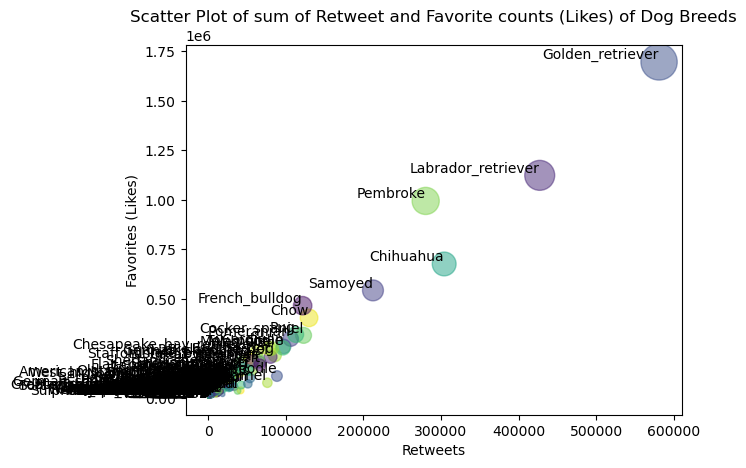

<Figure size 640x480 with 0 Axes>

In [72]:
#plotting the queried dataset
labeled_scatter(df_q1.retweet_count.values,
                df_q1.favorite_count.values,
                df_q1.index.values,
                'Retweets',
                'Favorites (Likes)',
                'Scatter Plot of sum of Retweet and Favorite counts (Likes) of Dog Breeds')
plt.savefig('fig_1.png')

The Golden Retriever is the dog with the highest retweets.

<a id = 'eda2'></a>
### 2. Which dog names are the top 10 most common?

In [73]:
#aggregate the dog names by value counts
dog_names_freq = df.name.value_counts()
top_10 = dog_names_freq.sort_values(ascending= False)[:10]

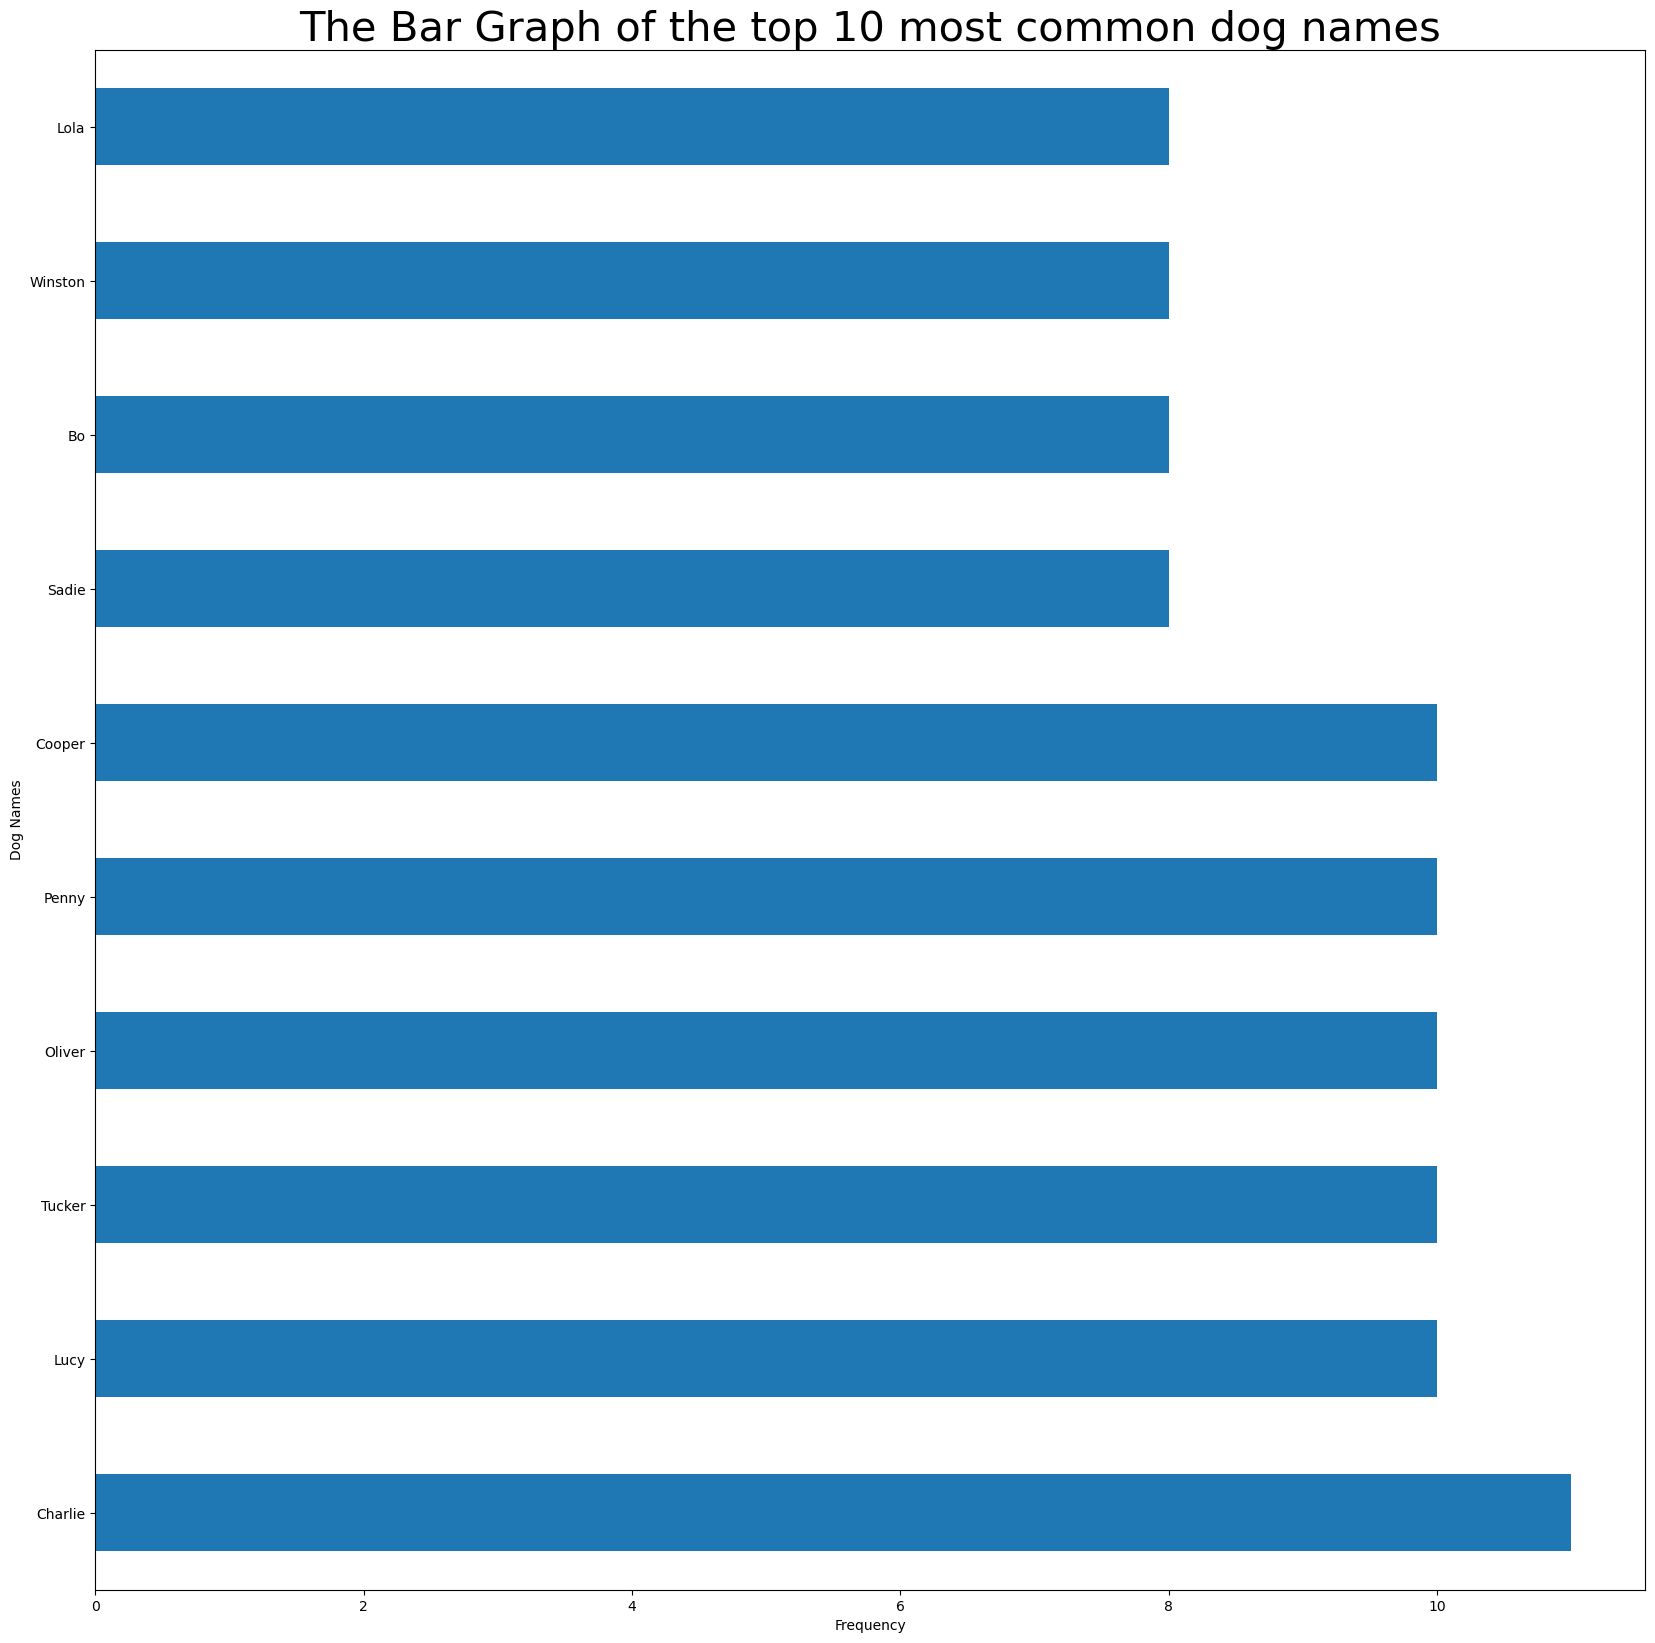

In [74]:
top_10.plot(kind = 'barh', figsize = figsize)
plt.ylabel('Dog Names')
plt.xlabel('Frequency')
plt.title('The Bar Graph of the top 10 most common dog names',fontdict={
    'fontsize':30
})
plt.savefig("fig_2.png")

<a id='eda3'></a>

### 3.  Did likes and retweets from #WeRateDogs decrease or increase overtime?

In [75]:
# Calculate the change in retweet and favorite counts over the years

#group data by the sum of their retweet_count and favorite_count by month
df_month_grp = df.groupby(pd.Grouper(key='timestamp',axis=0,freq='M'))[['retweet_count','favorite_count']].sum()

In [76]:
#Calculate the percentage change in retweet_count and favorite_count
shifted_df_month_grp = df_month_grp.shift(1).fillna(0)

#Calculate percentage change in retweet_count 
df_month_grp['percent_chg_retweet_count'] = ((df_month_grp.retweet_count - shifted_df_month_grp.retweet_count)/df_month_grp.retweet_count)*100

#Calculate percentage change in favorite_count
df_month_grp['percent_chg_favorite_count']= ((df_month_grp.favorite_count - shifted_df_month_grp.favorite_count)/df_month_grp.favorite_count)*100

In [77]:
df_month_grp

,retweet_count,favorite_count,percent_chg_retweet_count,percent_chg_favorite_count
timestamp,,,,
2015-11-30,160130.0,366498.0,100.000000,100.000000
2015-12-31,557795.0,1290510.0,71.292321,71.600530
2016-01-31,254018.0,668534.0,-119.588769,-93.035807
2016-02-29,176525.0,473156.0,-43.899164,-41.292512
2016-03-31,196768.0,554068.0,10.287750,14.603262
2016-04-30,87113.0,254008.0,-125.876735,-118.130138
2016-05-31,122696.0,343518.0,29.000945,26.056859
2016-06-30,329094.0,761103.0,62.717035,54.865767
2016-07-31,281933.0,614307.0,-16.727733,-23.896195


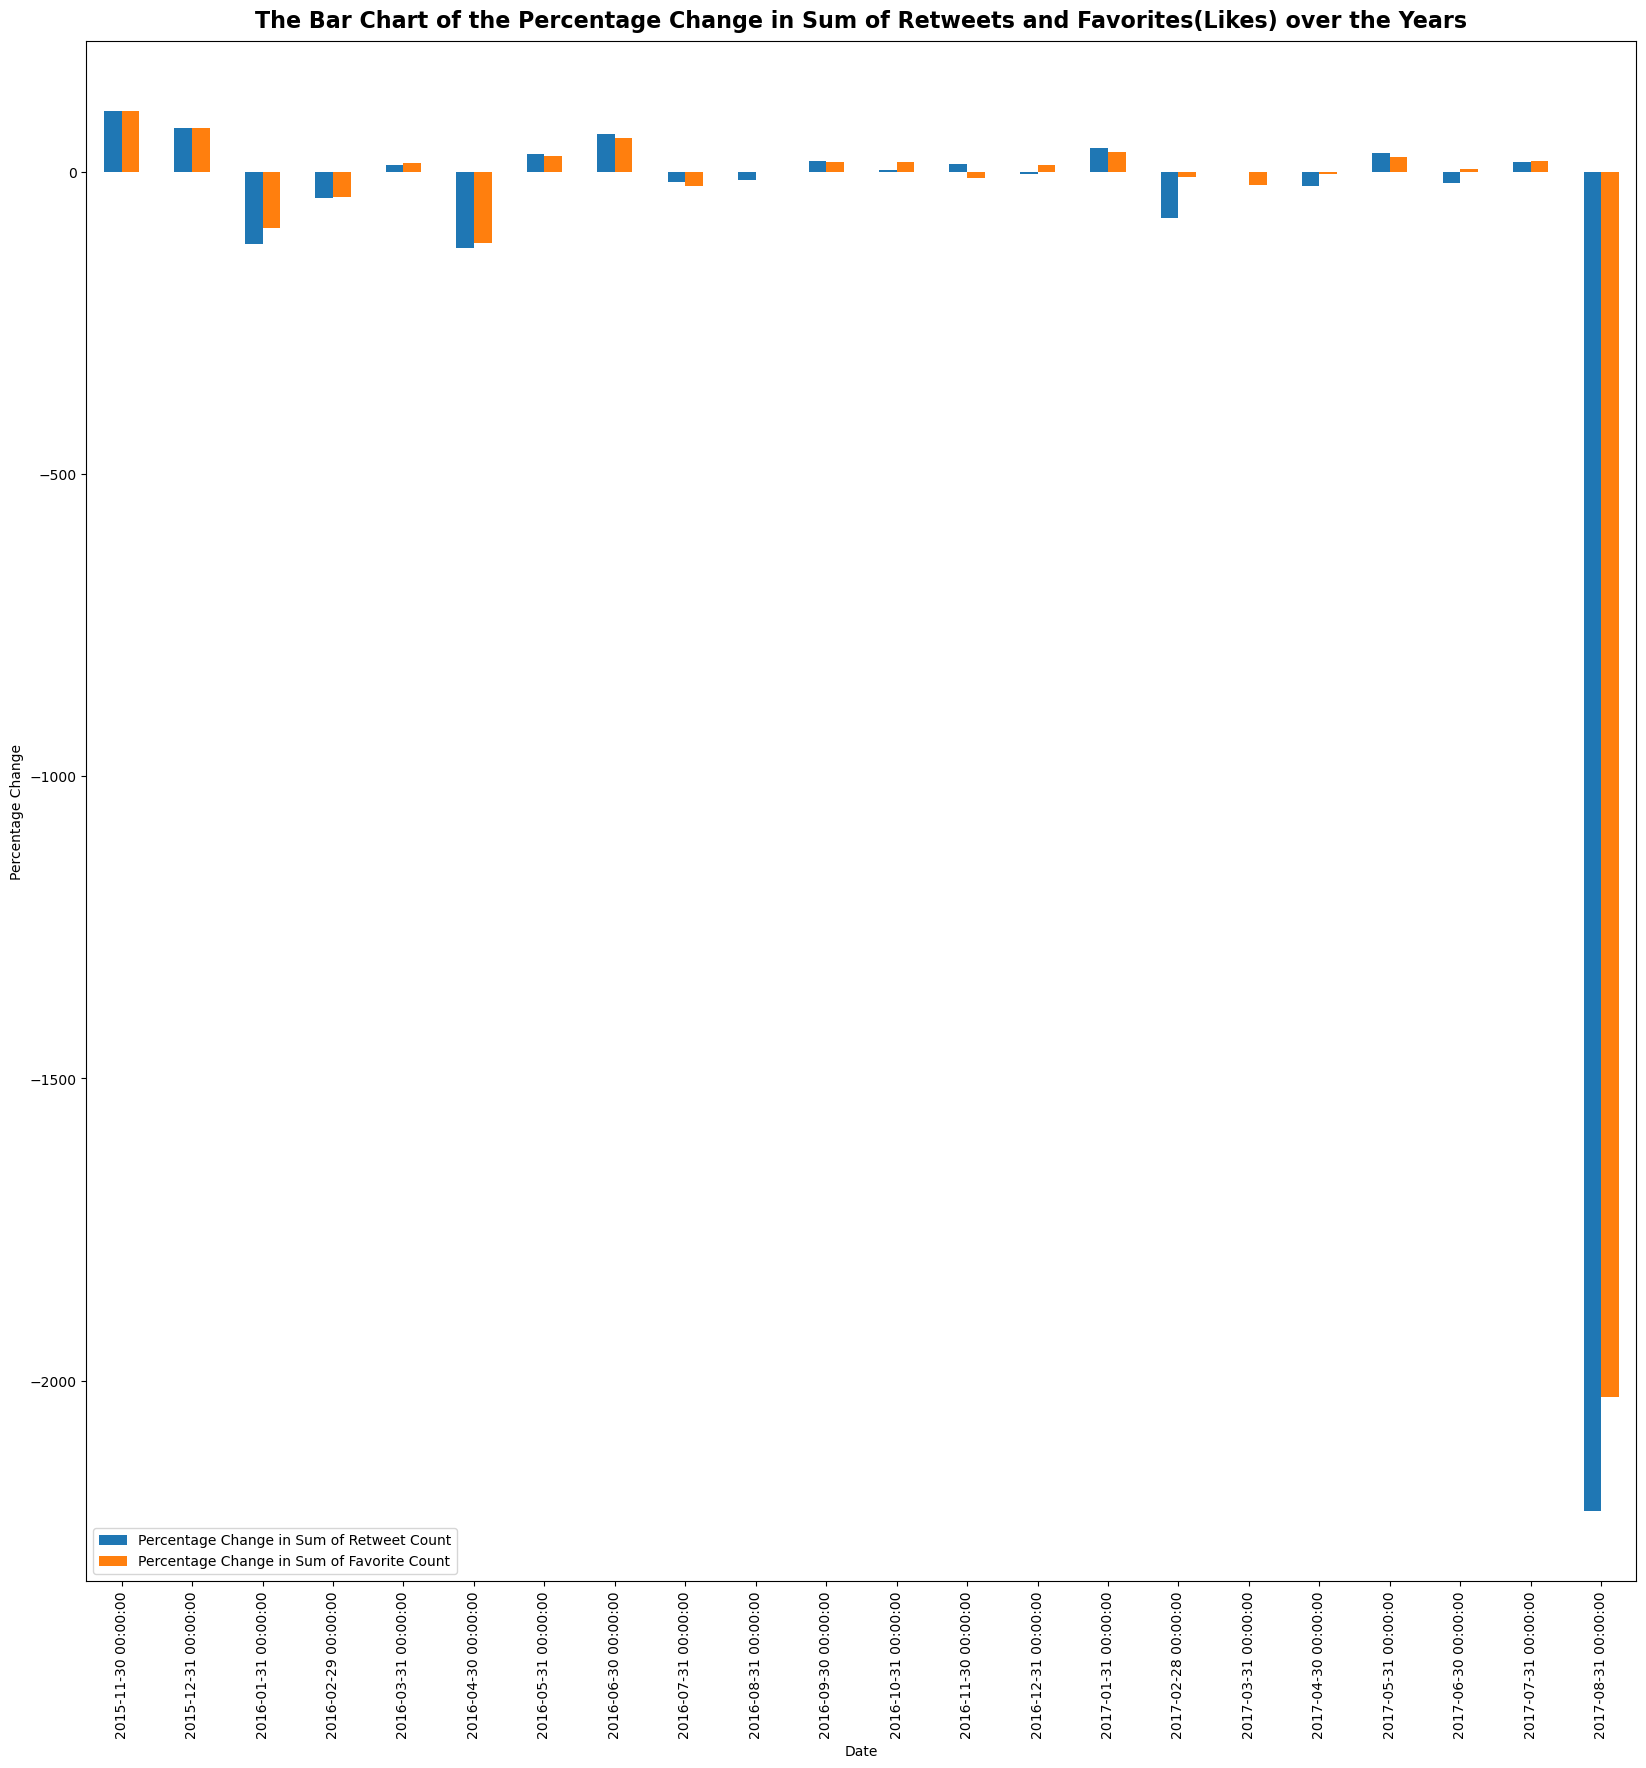

In [78]:
#plotting the bar graph of percentage change in retweet and favorite count over the months
df_month_grp[['percent_chg_retweet_count','percent_chg_favorite_count']].plot(kind='bar', figsize = figsize);
plt.title('The Bar Chart of the Percentage Change in Sum of Retweets and Favorites(Likes) over the Years',pad = 10,fontdict= {
    'fontsize':16,
    'fontweight':'bold'
})
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend(['Percentage Change in Sum of Retweet Count', 'Percentage Change in Sum of Favorite Count'],loc = 'lower left')
plt.savefig('fig_3.png')

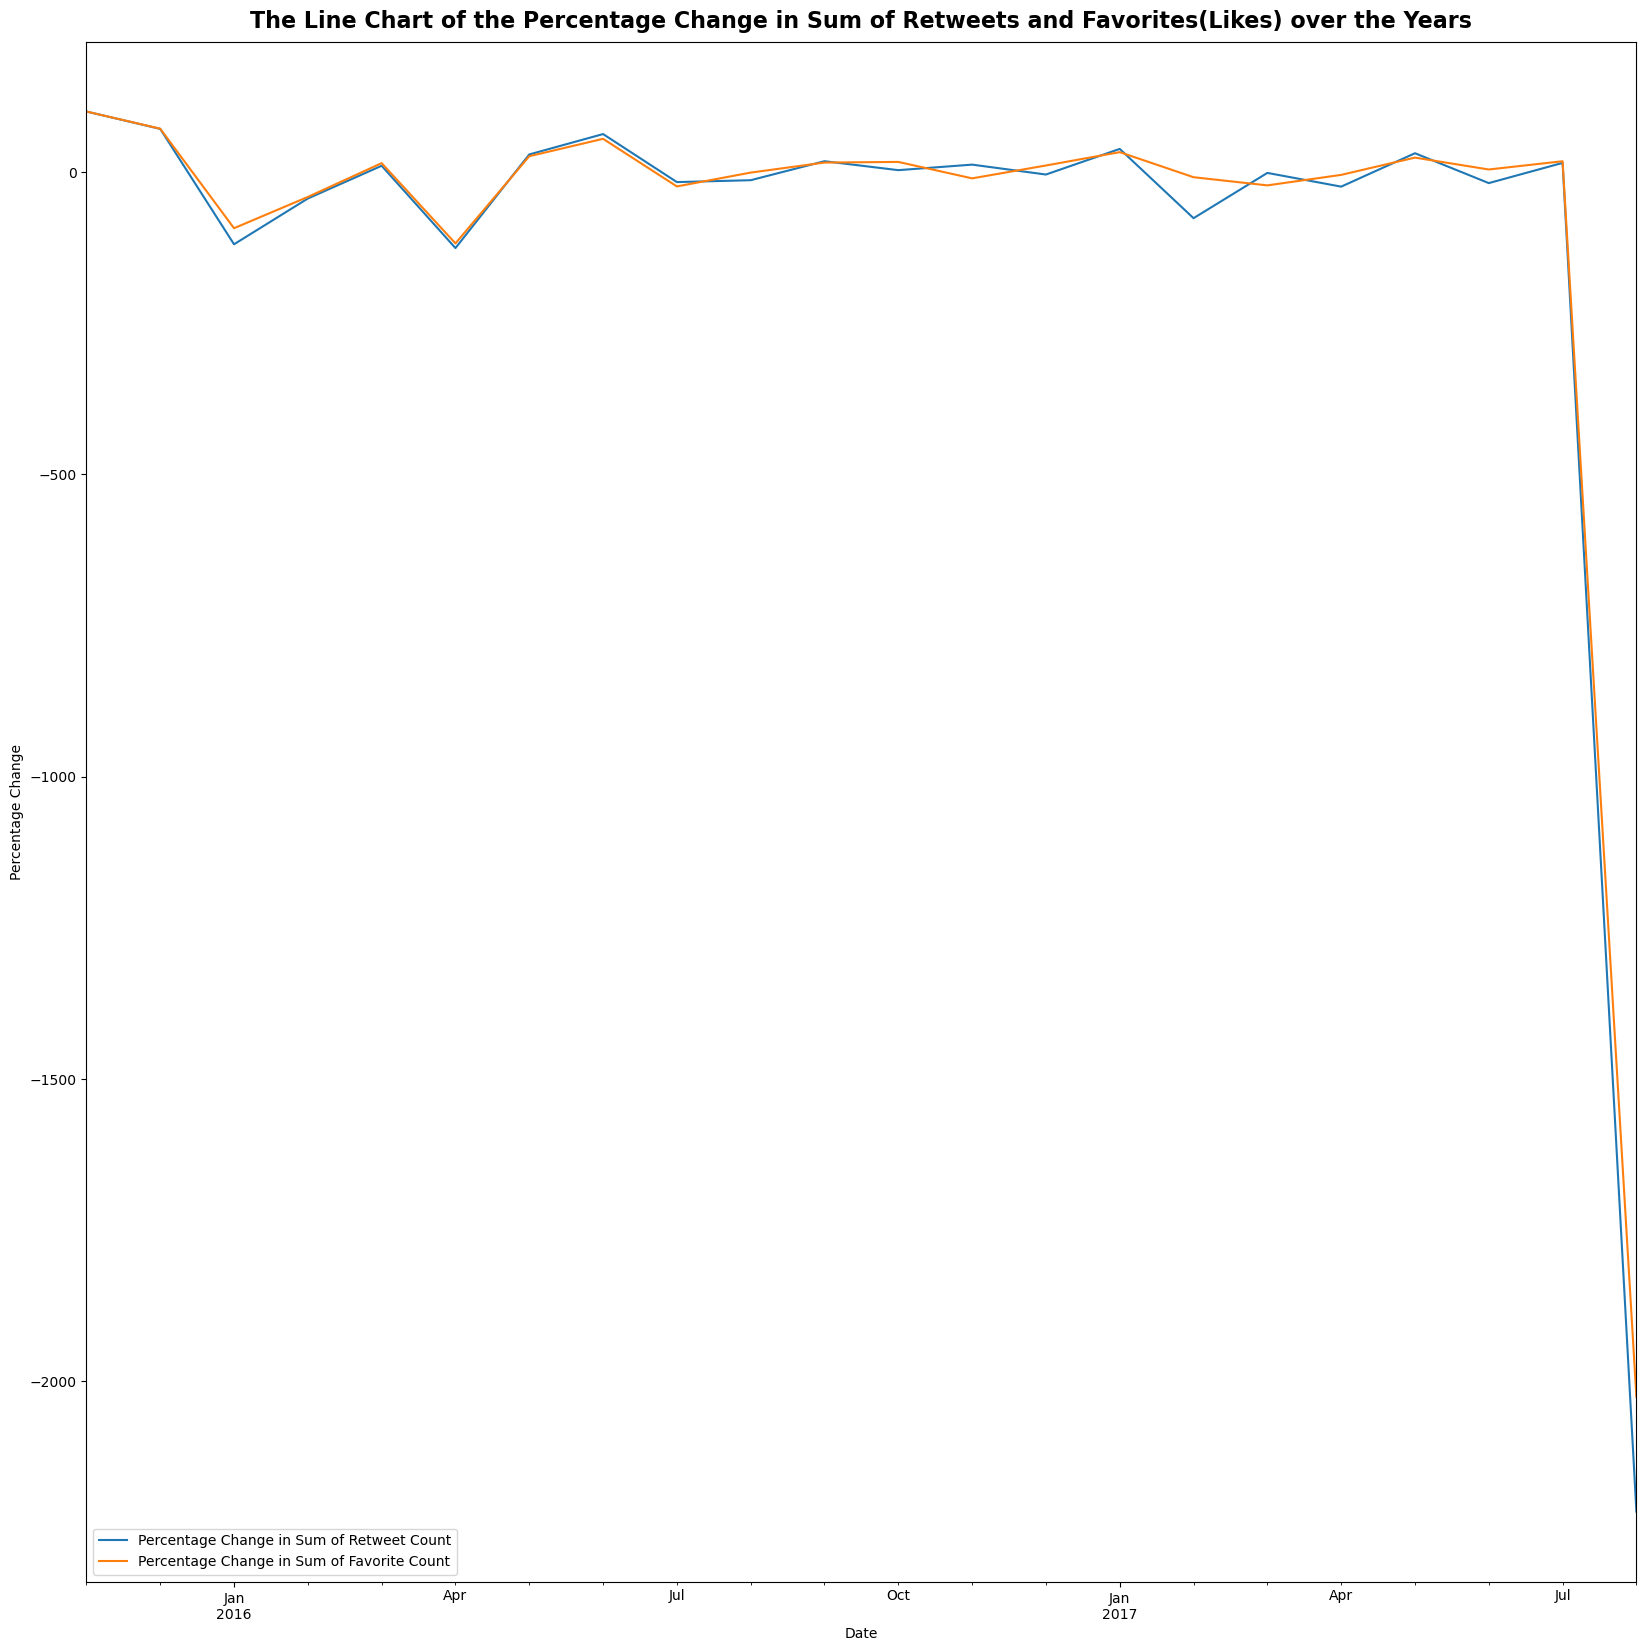

In [79]:
#plotting the line graph of percentage change in retweet and favorite count over the months
df_month_grp[['percent_chg_retweet_count','percent_chg_favorite_count']].plot(kind='line', figsize = figsize);
plt.title('The Line Chart of the Percentage Change in Sum of Retweets and Favorites(Likes) over the Years',pad = 10,fontdict= {
    'fontsize':16,
    'fontweight':'bold'
})
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend(['Percentage Change in Sum of Retweet Count', 'Percentage Change in Sum of Favorite Count'],loc = 'lower left')
plt.savefig('fig_4.png')

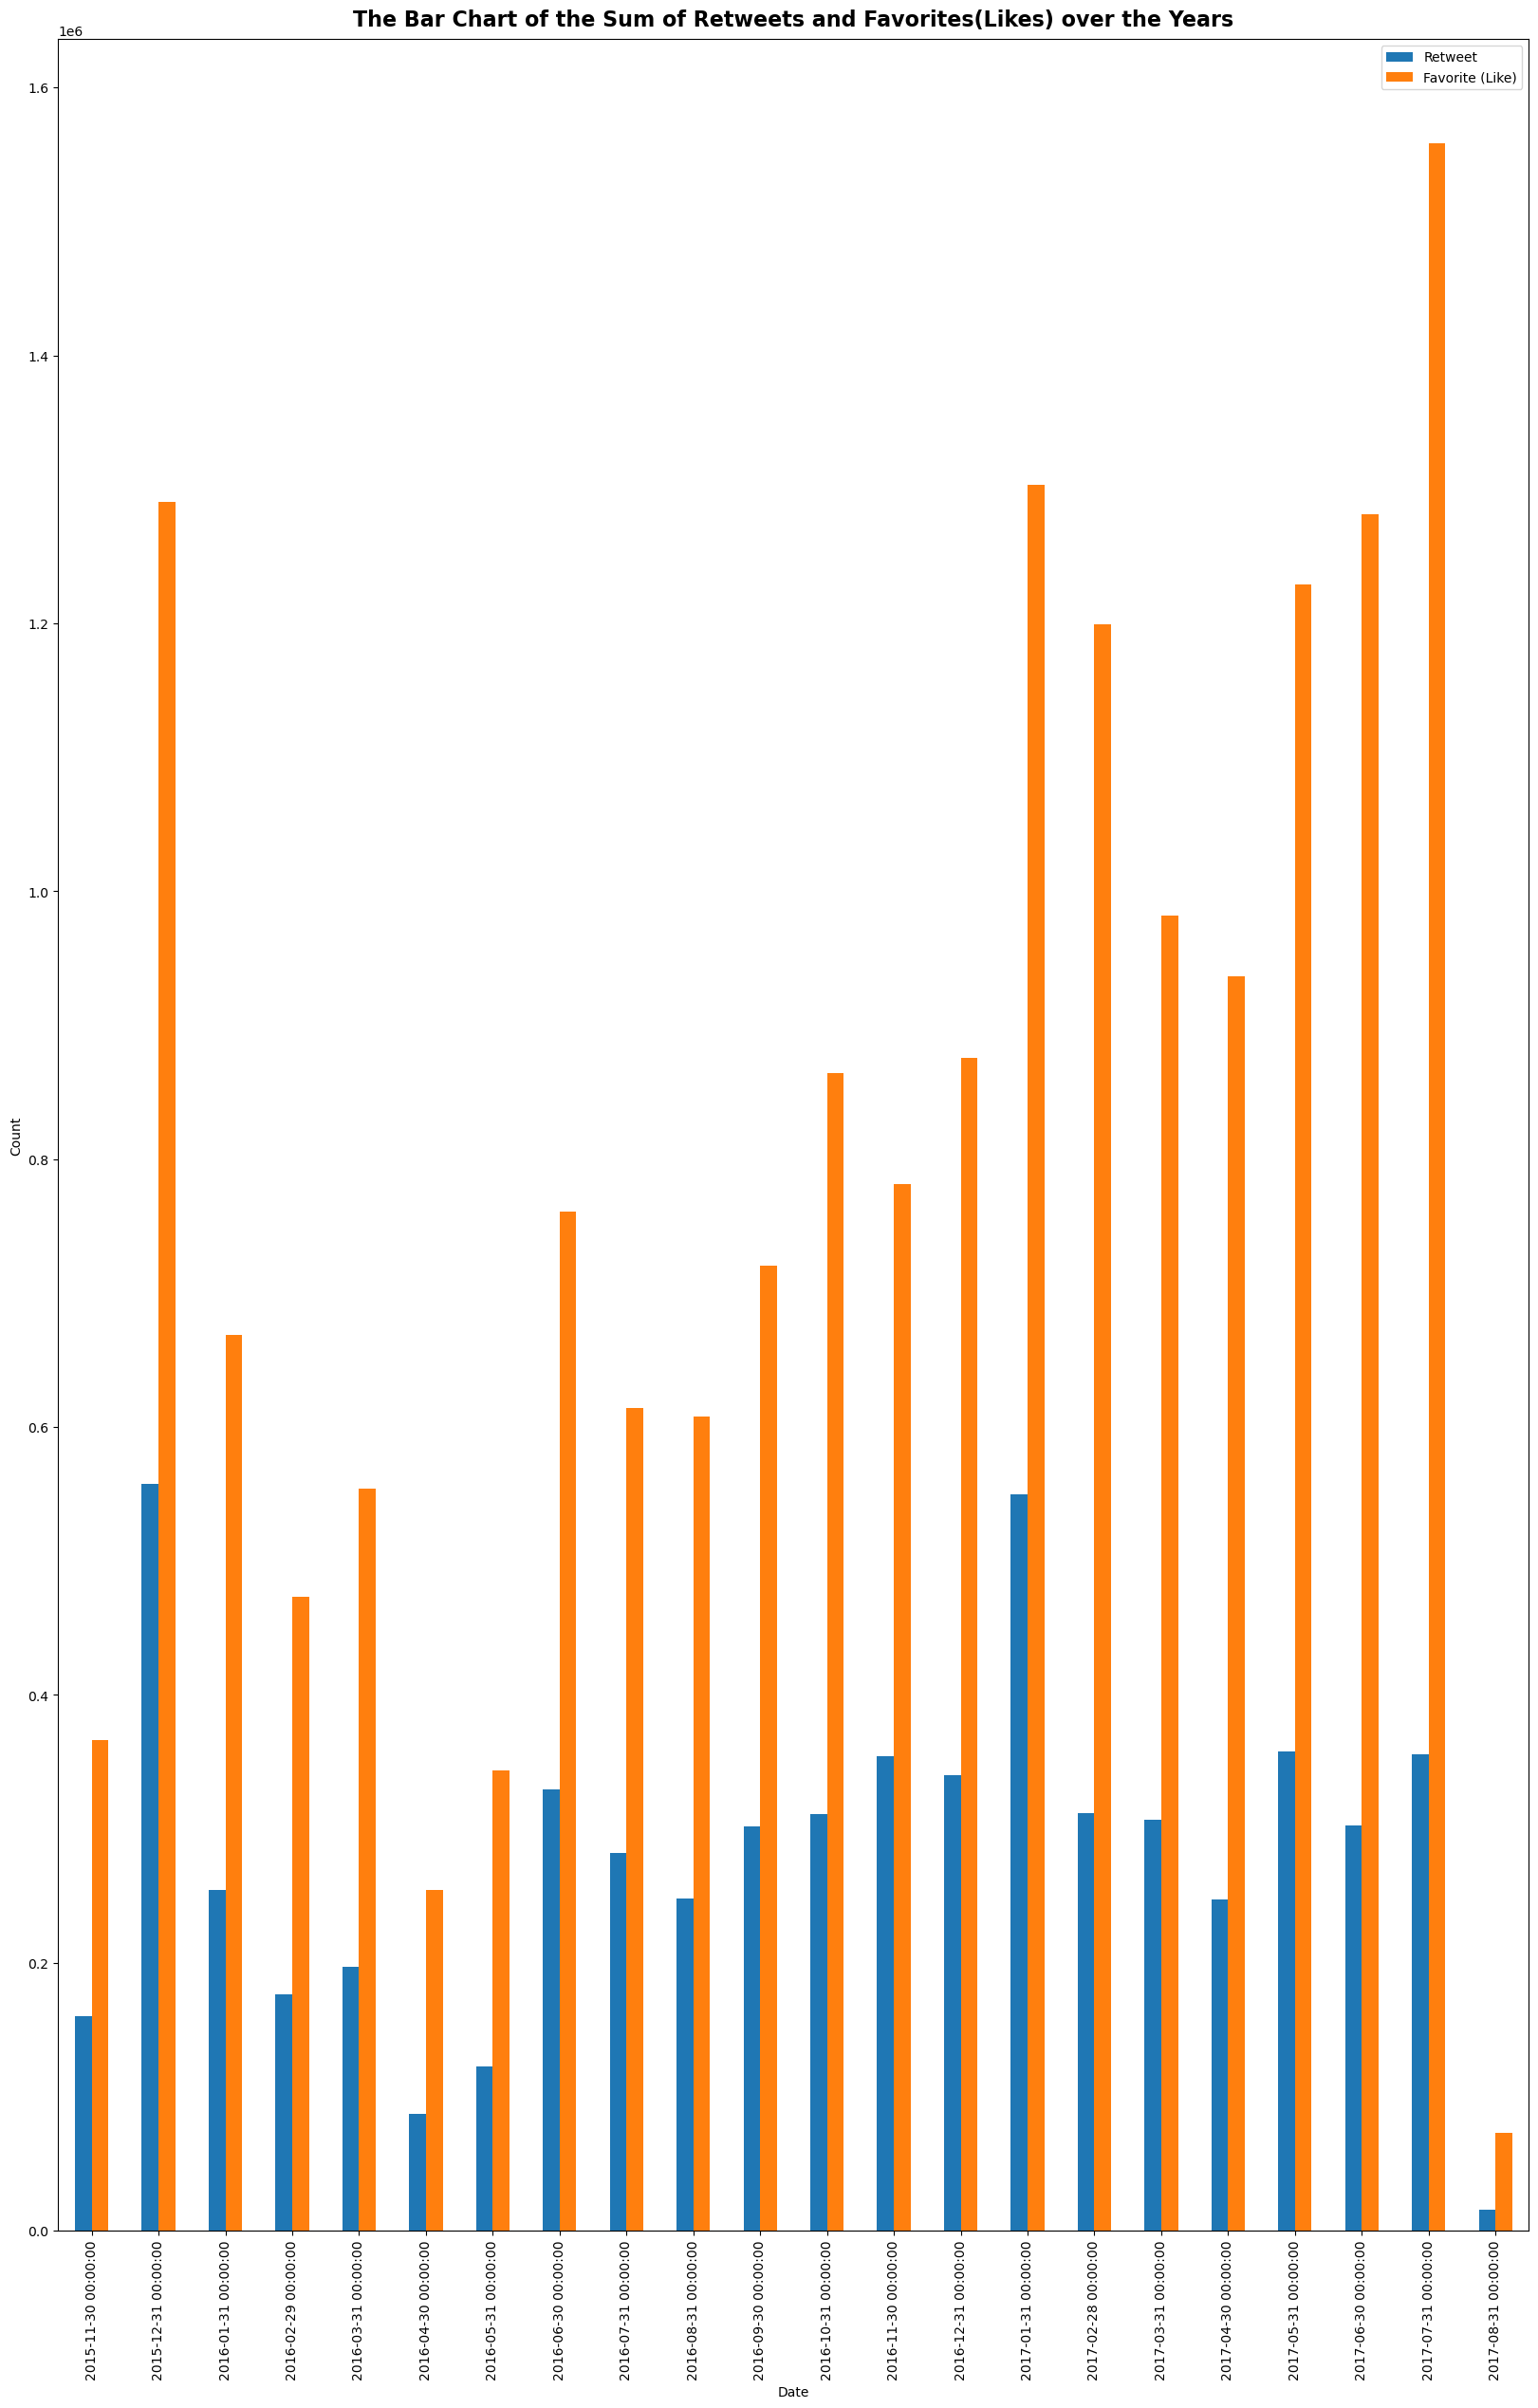

In [80]:
#plotting the bar chart of the sum of retweet and favorite counts over years
df_month_grp[['retweet_count','favorite_count']].plot(kind='bar',figsize = (20,30))
plt.title('The Bar Chart of the Sum of Retweets and Favorites(Likes) over the Years',pad = 10,fontdict= {
    'fontsize':16,
    'fontweight':'bold'
})
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(['Retweet','Favorite (Like)']);
plt.savefig('fig_5.png')

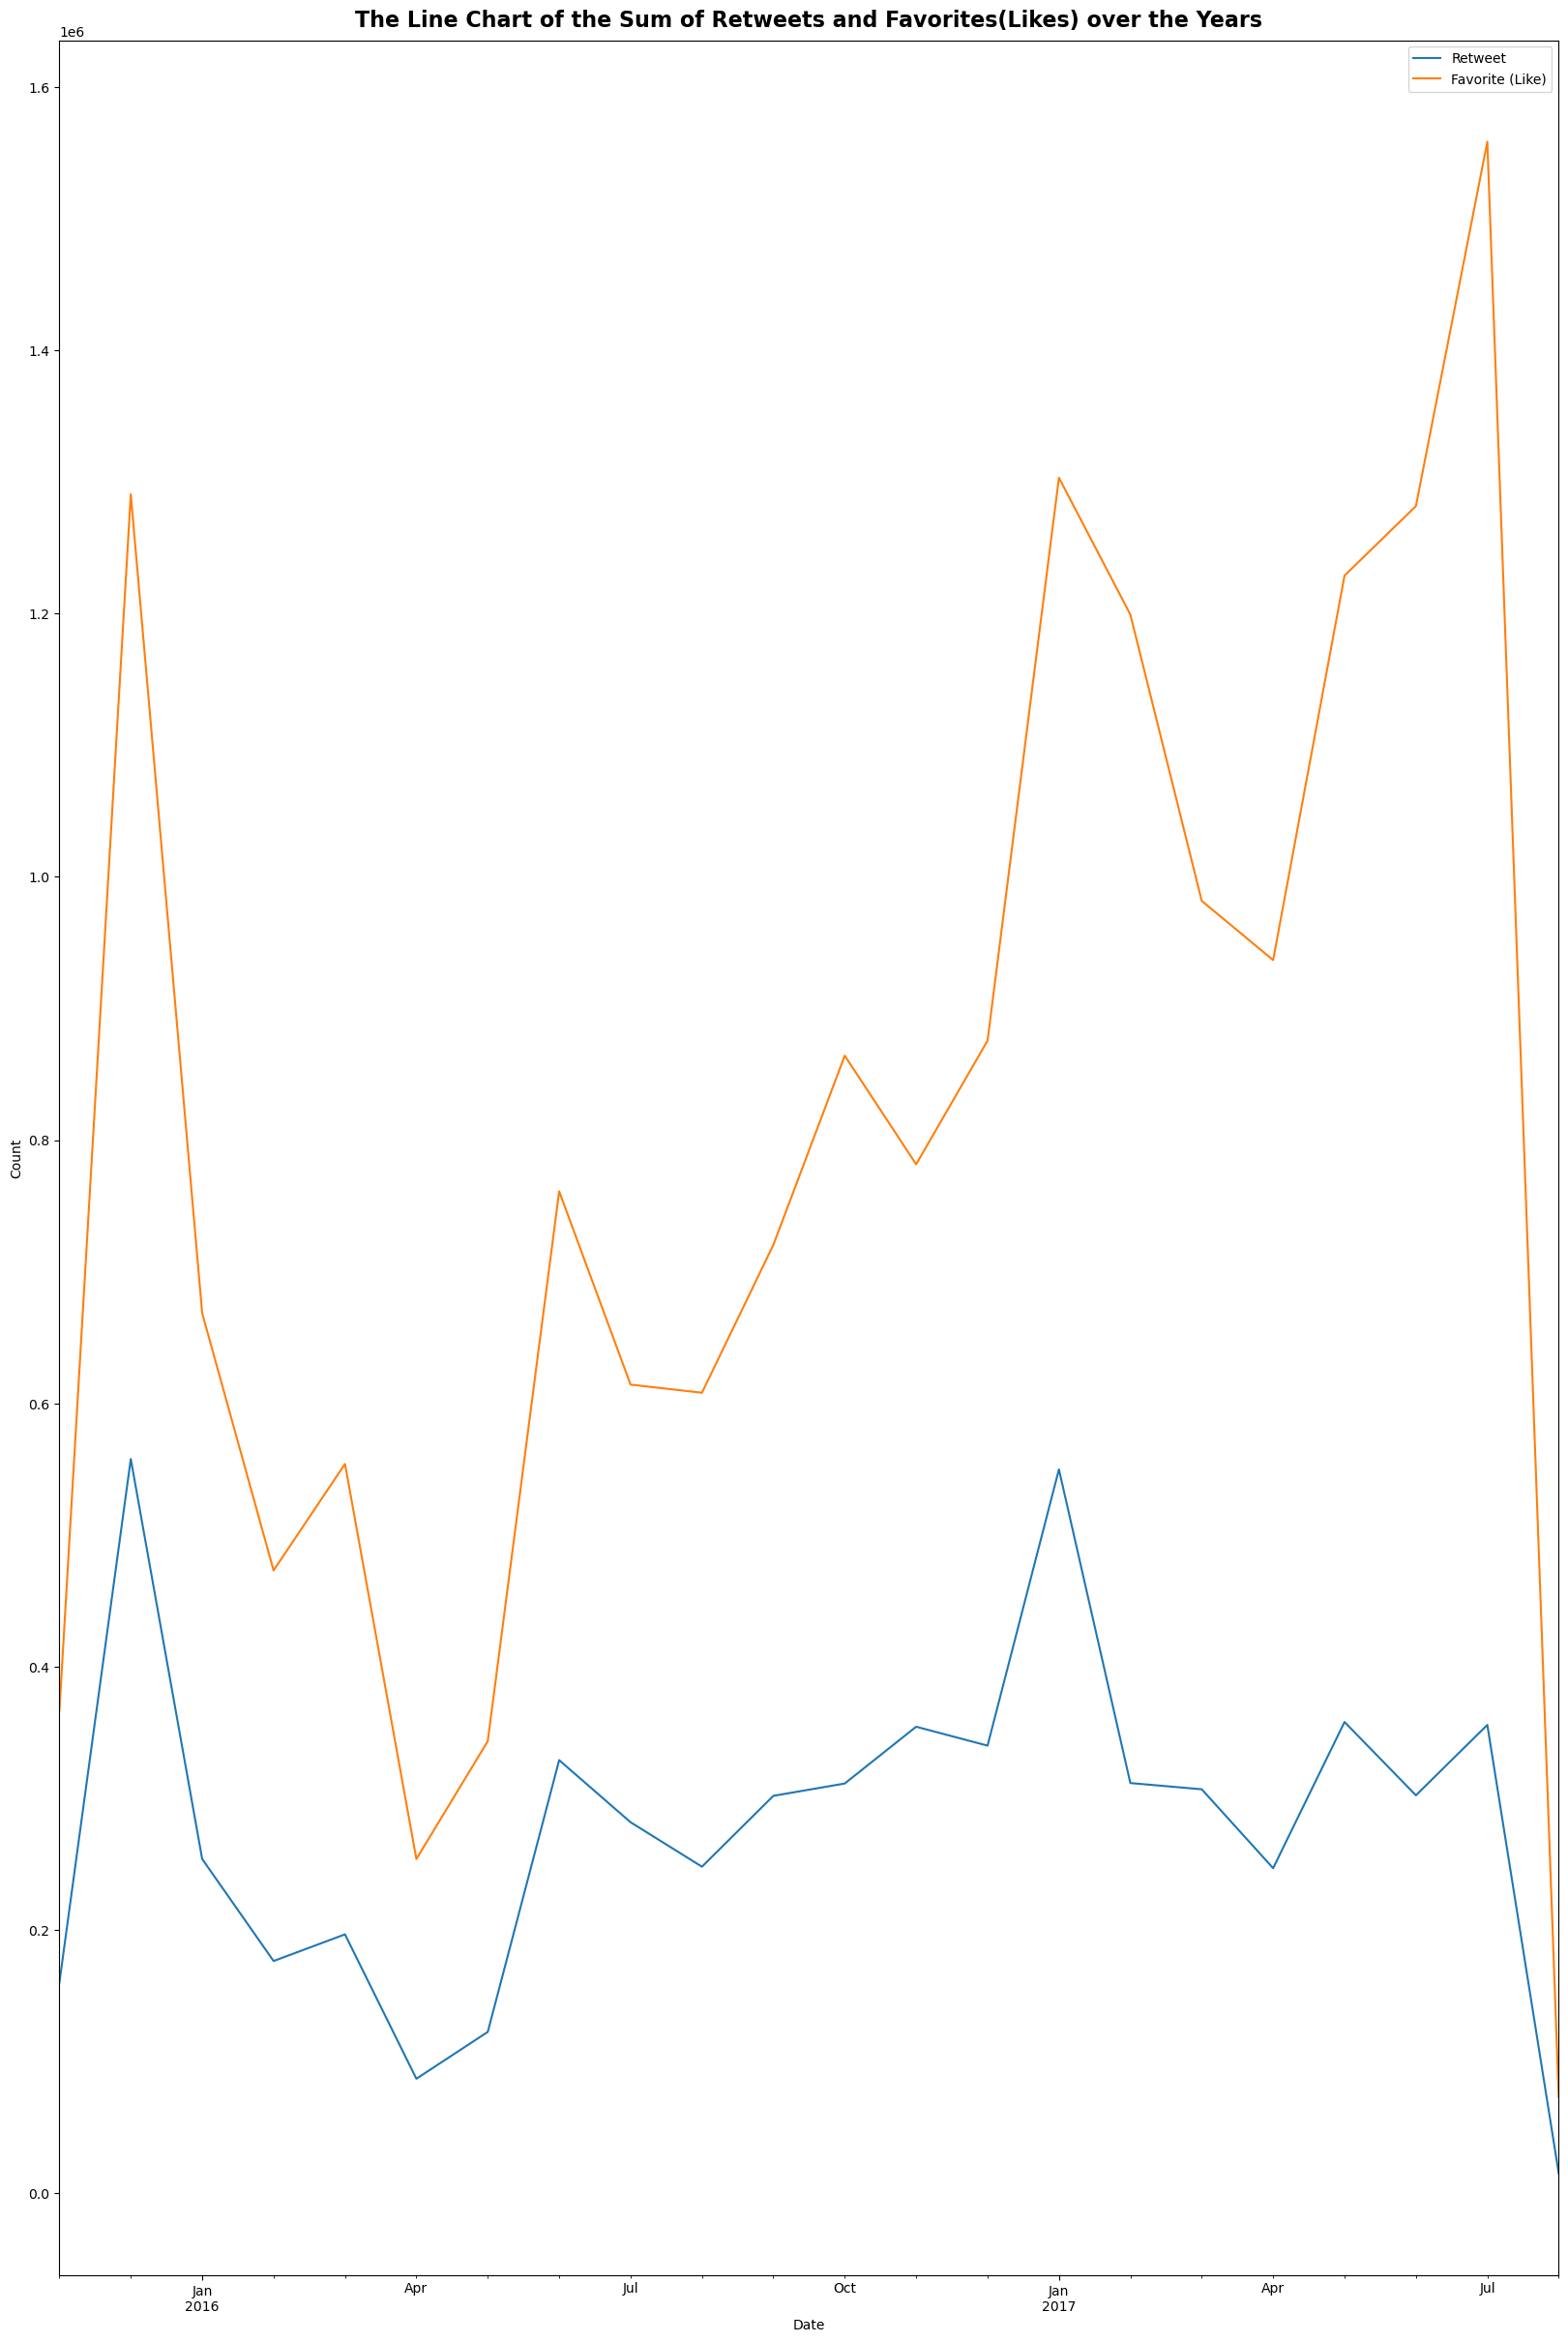

In [81]:
df_month_grp[['retweet_count','favorite_count']].plot(figsize = (20,30))
plt.title('The Line Chart of the Sum of Retweets and Favorites(Likes) over the Years',pad = 10,fontdict= {
    'fontsize':16,
    'fontweight':'bold'
})
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(['Retweet','Favorite (Like)']);
plt.savefig('fig_6.png')